In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
from zipfile import ZipFile
import numpy as np
import os
import shutil

# State Senate Special

## Final File Load

In [5]:
pwd

'/Users/lilyfalk/sandbox/pdv-va'

In [6]:
final = gpd.read_file('./vest_va_2016/va_2016_statesenate_special/va_2016_statesenate_special.shp')
final.head()

,COUNTYFP,LOCALITY,VTDST,PRECINCT,SOV_DIST,S16SOVDEM,S16SOVREP,S16SOVIND,S16SOVWRI,geometry
0,095,James City County,000304,Powhatan D,001,1369,1078,85,2,"POLYGON Z ((-76.76694 37.33789 0.00000, -76.76..."
1,095,James City County,000302,Powhatan B,001,561,394,34,0,"POLYGON Z ((-76.78970 37.32426 0.00000, -76.78..."
2,095,James City County,000501,Roberts A,001,927,363,41,1,"POLYGON Z ((-76.65883 37.20304 0.00000, -76.64..."
3,095,James City County,000503,Roberts C,001,312,135,25,2,"POLYGON Z ((-76.68089 37.26080 0.00000, -76.68..."
4,199,York County,000101,QUEENS LAKE,001,847,876,48,3,"POLYGON Z ((-76.68479 37.27077 0.00000, -76.68..."


In [7]:
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()

# Election Results

## District 1

In [8]:
df1 = pd.read_csv('./vest_va_2016/Virginia_Elections_Database__2016_Senate_of_Virginia_General_Election_District_1_including_precincts.csv')

In [9]:
df1.head()

,County/City,Ward,Pct,Taylor Montgomery Mason,Thomas Richard Holston,John Bernard Bloom,All Others,Total Votes Cast
0,NaN,NaN,NaN,Democratic,Republican,Independent,NaN,NaN
1,Hampton City,-,204 - Forrest,209,132,11,0.0,352
2,Hampton City,-,208 - Kraft,"1,601","1,081",146,9.0,"2,837"
3,Hampton City,-,214 - Tucker Capps,"1,348",777,93,11.0,"2,229"
4,Hampton City,-,Ab - Central Absentee Precinct,362,165,20,37.0,584


In [10]:
df1 = df1.iloc[1:]
df1['SOV_DIST'] = '1'
df1['LOCALITY'] = df1['County/City']
df1['S16SOVDEM'] = df1['Taylor Montgomery Mason']
df1['S16SOVREP'] = df1['Thomas Richard Holston']
df1['S16SOVIND'] = df1['John Bernard Bloom']
df1['S16SOVWRI'] = df1['All Others']
df1 = df1.drop(['County/City', 'Taylor Montgomery Mason', 'Thomas Richard Holston', 'John Bernard Bloom', 'All Others', 'Ward'], axis = 1)

df1['S16SOVDEM'] = df1['S16SOVDEM'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int)
df1['S16SOVREP'] = df1['S16SOVREP'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int)
df1['S16SOVIND'] = df1['S16SOVIND'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int)
df1['S16SOVWRI'] = df1['S16SOVWRI'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int)

print(df1.LOCALITY.nunique())
df1['COUNTYFP'] = df1['LOCALITY'].map(county_dict)
print(df1.COUNTYFP.nunique())

7
6


In [11]:
df1.groupby(['COUNTYFP']).sum()

,S16SOVDEM,S16SOVREP,S16SOVIND,S16SOVWRI
COUNTYFP,,,,
095,5083,3283,283,9
199,2325,1801,162,10
650,3524,2161,270,57
700,32019,21799,2487,193
800,1191,652,79,4
830,5109,2044,253,13


## District 5

In [12]:
df5 = pd.read_csv('./vest_va_2016/Virginia_Elections_Database__2016_Senate_of_Virginia_General_Election_District_5_including_precincts.csv')

In [13]:
df5.head()

,County/City,Ward,Pct,"Lionell Spruill, Sr.",All Others,Total Votes Cast
0,NaN,NaN,NaN,Democratic,NaN,NaN
1,Chesapeake City,-,3 - Camelot,"1,881",24,"1,905"
2,Chesapeake City,-,5 - Crestwood,"1,427",33,"1,460"
3,Chesapeake City,-,8 - South Norfolk Recreation,"1,422",70,"1,492"
4,Chesapeake City,-,10 - Oscar Smith,664,47,711


In [14]:
df5 = df5.iloc[1:]
df5['SOV_DIST'] = '5'
df5['LOCALITY'] = df5['County/City']
df5['S16SOVDEM'] = df5['Lionell Spruill, Sr.']
df5['S16SOVWRI'] = df5['All Others']
df5 = df5.drop(['County/City', 'Lionell Spruill, Sr.', 'All Others', 'Ward'], axis = 1)

df5['S16SOVDEM'] = df5['S16SOVDEM'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int)
df5['S16SOVWRI'] = df5['S16SOVWRI'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int)

print(df5.LOCALITY.nunique())
df5['COUNTYFP'] = df5['LOCALITY'].map(county_dict)
print(df5.COUNTYFP.nunique())

3
2


## Districts 1 and 5 together

In [15]:
elections = []
elections.append(df1)
elections.append(df5)

df = pd.concat(elections, axis = 0)
df = df[df['LOCALITY'] != 'TOTALS']
df = df.reset_index()
df = df.fillna(0)

In [16]:
def get_absentee_frac(prec_tot, county_tot, absentee_tot):
    '''A spec specifies in first line what function will do
    Returns fraction of county absentee votes for a precinct for a candidate
    
    Keyword arguments: (put inputs to funtions and say what they should be)
    precinct vote total for given candidate (int)
    county vote total for given candidate, absentee and provisional votes not included (int)
    absentee vote total for county for given candidate (int)
    
    "Pure function" bc only relies on inputs and outputs - only variables are ones that were passed as arguments
    '''
    if county_tot != 0:
        prec_frac = prec_tot/county_tot
        absentee_frac = prec_frac*absentee_tot
    else:
        absentee_frac = 0
    return absentee_frac

In [17]:
absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['COUNTYFP']).sum()
groupby_county_df_tot = df.groupby(['COUNTYFP']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('COUNTYFP').sum()

In [18]:
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
for index, precinct_total_row_by_candidate in df_no_absent_or_provisional.iterrows():
    #print(precinct_total_row_by_candidate)
    county_fips = precinct_total_row_by_candidate['COUNTYFP']
    county_total_row_by_candidate_no_absentee = groupby_county_tot_no_absentee.loc[county_fips]
    county_absentee_and_provisional_by_candidate = groupby_absentee_and_prov_tot.loc[county_fips]
    #print(precinct_total_row_by_candidate, county_total_row_by_candidate_no_absentee, county_absentee_and_provisional_by_candidate)
    for candidate, votes in county_total_row_by_candidate_no_absentee.to_dict().items():
        prec_tot = precinct_total_row_by_candidate[candidate]
        #print('precinct total: ', prec_tot)
        county_tot = votes
        #print('county total: ', county_tot)
        absentee_tot = county_absentee_and_provisional_by_candidate[candidate]
        #print('absentee total: ', absentee_tot)
        absentee_frac = get_absentee_frac(prec_tot, county_tot, absentee_tot)
        #print('absentee votes to allocate to precinct: ', absentee_frac)
        prec_with_absentee_allocation = round(prec_tot + absentee_frac)
        #print('new precinct total: ', prec_with_absentee_allocation)
        df_with_absentee_reallocated.loc[index, candidate] = round(prec_with_absentee_allocation) #index is row, candidate is column

In [19]:
df_with_absentee_reallocated.shape

(98, 10)

In [20]:
final.shape

(98, 10)

In [21]:
df_with_absentee_reallocated.columns

Index(['index', 'Pct', 'Total Votes Cast', 'SOV_DIST', 'LOCALITY', 'S16SOVDEM',
       'S16SOVREP', 'S16SOVIND', 'S16SOVWRI', 'COUNTYFP'],
      dtype='object')

In [22]:
df1.COUNTYFP.value_counts()

700    34
095     8
650     5
199     4
830     4
800     3
Name: COUNTYFP, dtype: int64

In [23]:
df5.COUNTYFP.value_counts()

550    30
710    26
Name: COUNTYFP, dtype: int64

## Check Column sums

In [24]:
column_list = ['S16SOVDEM', 'S16SOVREP', 'S16SOVIND', 'S16SOVWRI']

In [25]:
groupby_county_final = final.groupby('COUNTYFP').sum()
groupby_df_with_absentee_reallocated = df_with_absentee_reallocated.groupby('COUNTYFP').sum()
df_absentee_reallocate_with_final = pd.merge(groupby_df_with_absentee_reallocated, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))

In [26]:
def sum_checker(df, column_list):
    list_max = 0
    for i in column_list:
        left_sum = df[i+'_x'].sum()
        right_sum = df[i+'_y'].sum()
        if (left_sum == right_sum):
            print('column: ', i, ' have the same sums')
        
        else:
            diff = abs(left_sum - right_sum)
            percent = abs(left_sum - right_sum)/left_sum
            print('column: ', i)
            print('RDH sum is ', str(left_sum))
            print('Partner sum is ', str(right_sum))
            print('their (absolute) difference is ', str(diff))
            print('As a percentage of DF1 this is ', str(round(percent*100,5)) + '%')
            if (percent>list_max):
                list_max = percent
            print('')
    print('The max difference (as a percent of the total of on DF column is: ', str(round(list_max,5)))

In [27]:
sum_checker(df_absentee_reallocate_with_final, column_list)

column:  S16SOVDEM
RDH sum is  116241.0
Partner sum is  116240
their (absolute) difference is  1.0
As a percentage of DF1 this is  0.00086%

column:  S16SOVREP
RDH sum is  31737.0
Partner sum is  31740
their (absolute) difference is  3.0
As a percentage of DF1 this is  0.00945%

column:  S16SOVIND
RDH sum is  3530.0
Partner sum is  3534
their (absolute) difference is  4.0
As a percentage of DF1 this is  0.11331%

column:  S16SOVWRI
RDH sum is  2909.0
Partner sum is  2913
their (absolute) difference is  4.0
As a percentage of DF1 this is  0.1375%

The max difference (as a percent of the total of on DF column is:  0.00138


## Create unique id

In [28]:
set(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3)) - set(final.COUNTYFP + final.VTDST.str.slice(start = 3))

{'55010 ',
 '55011 ',
 '55012 ',
 '55013 ',
 '55015 ',
 '55018 ',
 '55022 ',
 '55024 ',
 '55025 ',
 '55026 ',
 '55029 ',
 '5503 -',
 '55030 ',
 '55031 ',
 '55032 ',
 '55033 ',
 '55040 ',
 '55042 ',
 '55045 ',
 '55048 ',
 '5505 -',
 '55050 ',
 '55053 ',
 '55055 ',
 '55056 ',
 '55057 ',
 '55058 ',
 '5508 -',
 '8301 -',
 '8302 -'}

In [29]:
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst

In [30]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)
df_with_absentee_reallocated.head()

,index,Pct,Total Votes Cast,SOV_DIST,LOCALITY,S16SOVDEM,S16SOVREP,S16SOVIND,S16SOVWRI,COUNTYFP,vtdst
0,2.0,204 - Forrest,352,1,Hampton City,233.0,143.0,12.0,0.0,650,204
1,5.0,208 - Kraft,"2,837",1,Hampton City,1787.0,1174.0,158.0,26.0,650,208
2,8.0,214 - Tucker Capps,"2,229",1,Hampton City,1504.0,844.0,100.0,31.0,650,214
5,9.0,201 - Jamestown A,730,1,James City County,490.0,318.0,19.0,0.0,095,201
6,10.0,202 - Jamestown B,"2,208",1,James City County,1424.0,995.0,78.0,3.0,095,202


In [31]:
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.vtdst
final['unique_id'] = final.COUNTYFP + final.VTDST.str.slice(start = 3)
print(set(df_with_absentee_reallocated.unique_id) - set(final.unique_id))
print(set(final.unique_id) - set(df_with_absentee_reallocated.unique_id))

set()
set()


# Shapefile

In [32]:
county_fips = []
for directory in os.listdir('./vest_va_2016/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])
        
proj = final.crs   

county_vtds = []
for i in county_fips: #i dont have fips_codes file
    ref = './vest_va_2016/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
    print(i, ' added to list')
    county_vtds.append(vtd_shp)

global shp_vtd
shp_vtd = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 

county_sldu = []
for i in county_fips: #i dont have fips_codes file
    ref = './vest_va_2016/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    sldu_ref = ref + i + '/PVS_19_v2_sldu_' + i + '.shp' #PVS_19_v2_sldl_51650
    sldu_shp = gpd.read_file(sldu_ref)
    print(i, ' added to list')
    county_sldu.append(sldu_shp)

global shp_sldu
shp_sldu = gpd.GeoDataFrame(pd.concat(county_sldu, axis = 0) , crs = proj) 

overlay = gpd.overlay(shp_sldu, shp_vtd, how='intersection', make_valid=True, keep_geom_type=True)
shp = overlay[(overlay.SLDUST == '001') | (overlay.SLDUST == '005')]

51580  added to list
51117  added to list
51121  added to list
51119  added to list
51770  added to list
51181  added to list
51175  added to list
51143  added to list
51520  added to list
51127  added to list
51740  added to list
51111  added to list
51145  added to list
51510  added to list
51187  added to list
51173  added to list
51001  added to list
51650  added to list
51037  added to list
51063  added to list
51097  added to list
51099  added to list
51009  added to list
51660  added to list
51036  added to list
51031  added to list
51007  added to list
51053  added to list
51065  added to list
51091  added to list
51047  added to list
51071  added to list
51085  added to list
51049  added to list
51620  added to list
51680  added to list
51025  added to list
51013  added to list
51810  added to list
51077  added to list
51083  added to list
51079  added to list
51610  added to list
51041  added to list
51015  added to list
51023  added to list
51820  added to list
51169  added 

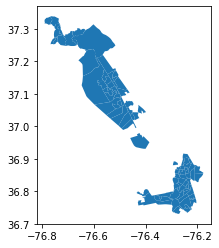

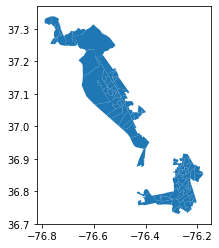

In [33]:
shp.plot()
final.plot()

In [34]:
shp.shape

(91, 42)

In [35]:
final.shape

(98, 11)

In [36]:
print((set(shp.COUNTYFP_1 + shp.VTDST.str.slice(start = 3)) - set(final.COUNTYFP + final.VTDST.str.slice(start = 3))))
print((set(final.COUNTYFP + final.VTDST.str.slice(start = 3)) - set(shp.COUNTYFP_1 + shp.VTDST.str.slice(start = 3))))

{'710511'}
{'700219', '550040', '710203', '710403', '700305', '650204', '710218', '800704'}


In [37]:
shp['unique_id'] = shp['COUNTYFP_1'] + shp['VTDST'].str.slice(start = 3)

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [72]:
set(df_with_absentee_reallocated.SOV_DIST) - set(final.SOV_DIST)

{'1', '5'}

In [38]:
shp[shp['unique_id'] == '710511']

,STATEFP_1,COUNTYFP_1,SLDUST,NAMELSAD_1,LSAD_1,PARTFLG,CHNG_TYPE_1,EFF_DATE,NEW_NAME,NEW_CODE,...,ORIG_NAME,ORIG_CODE,RELATE_2,NAME_2,VINTAGE_2,FUNCSTAT_2,JUSTIFY_2,MTFCC,geometry,unique_id
1525,51,710,005,State Senate District 5,LU,Y,None,None,None,None,...,None,None,None,Crossroads,90,N,None,G5240,"POLYGON Z ((-76.25397 36.91611 0.00000, -76.25...",710511


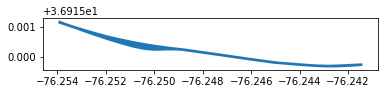

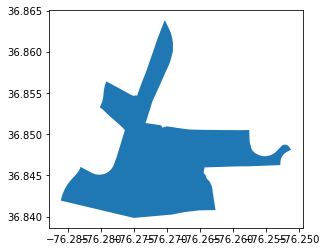

In [39]:
shp[shp['unique_id'] == '710511'].plot()
final[(final['unique_id'] == '710403')].plot() #(final['unique_id'] == '710218')] |  | (final['unique_id'] == '710203')
#Within county none match up

In [44]:
set(final.unique_id) - set(df_with_absentee_reallocated.unique_id)

set()

In [41]:
set(df_with_absentee_reallocated.unique_id) - set(shp.unique_id)

{'550040',
 '650204',
 '700219',
 '700305',
 '710203',
 '710218',
 '710403',
 '800704'}

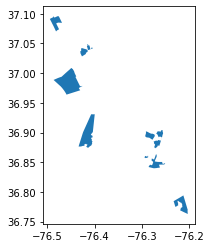

In [69]:
final[final['unique_id'].isin(list(set(df_with_absentee_reallocated.unique_id) - set(shp.unique_id)))].plot()

In [67]:
final[final['unique_id'].isin(list(set(df_with_absentee_reallocated.unique_id) - set(shp.unique_id)))]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,SOV_DIST,S16SOVDEM,S16SOVREP,S16SOVIND,S16SOVWRI,geometry,unique_id
23,550,Chesapeake City,000040,River Birch,005,1658,0,0,113,"POLYGON Z ((-76.23347 36.78440 0.00000, -76.23...",550040
31,650,Hampton City,000204,FORREST,001,233,144,12,0,"MULTIPOLYGON Z (((-76.42989 37.03724 0.00000, ...",650204
56,700,Newport News City,000305,Downtown,001,290,72,21,3,"POLYGON Z ((-76.48620 36.98860 0.00000, -76.48...",700305
58,700,Newport News City,000219,Deer Park,001,1118,545,78,8,"POLYGON Z ((-76.49411 37.09133 0.00000, -76.49...",700219
65,710,Norfolk City,000203,Ghent Square,005,198,0,0,6,"POLYGON Z ((-76.28798 36.86092 0.00000, -76.28...",710203
71,710,Norfolk City,000218,Willard,005,1509,0,0,131,"MULTIPOLYGON Z (((-76.29326 36.89415 0.00000, ...",710218
81,710,Norfolk City,000403,Brambleton,005,892,0,0,3,"POLYGON Z ((-76.28599 36.84207 0.00000, -76.28...",710403
96,800,Suffolk City,000704,BURBAGE GRANT,001,1191,652,79,4,"POLYGON Z ((-76.42102 36.87823 0.00000, -76.42...",800704


In [42]:
set(shp.unique_id) - set(df_with_absentee_reallocated.unique_id)

{'710511'}

In [68]:
shp[shp.unique_id == '710511']

,STATEFP_1,COUNTYFP_1,SLDUST,NAMELSAD_1,LSAD_1,PARTFLG,CHNG_TYPE_1,EFF_DATE,NEW_NAME,NEW_CODE,...,ORIG_NAME,ORIG_CODE,RELATE_2,NAME_2,VINTAGE_2,FUNCSTAT_2,JUSTIFY_2,MTFCC,geometry,unique_id
1525,51,710,005,State Senate District 5,LU,Y,None,None,None,None,...,None,None,None,Crossroads,90,N,None,G5240,"POLYGON Z ((-76.25397 36.91611 0.00000, -76.25...",710511


### Join election results and shapefile

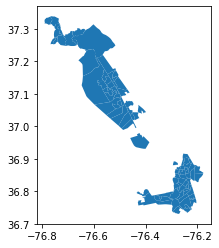

In [45]:
join = gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id', how = 'inner'), crs = proj)
join.plot()

# Validation 

## Validating Shapefile

Here, I merge the shp joined to the election results to the final file to compare

In [46]:
shp_final_merge = pd.merge(join, final, on = 'unique_id', how = 'outer', suffixes = ['_x', '_y'])

join['geometry'].geom_almost_equals(final['geometry'], decimal = 0)

shp_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_x')
final_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_y')
vals = shp_shapes.geom_almost_equals(final_shapes, decimal = 0)

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [47]:
print(vals.value_counts())

True     57
False    41
dtype: int64


700    14
550    12
710     9
650     2
830     1
800     1
199     1
095     1
Name: unique_id, dtype: int64


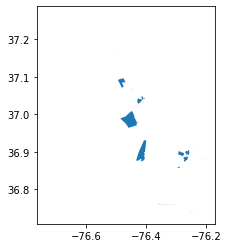

In [48]:
print(shp_final_merge[~vals]['unique_id'].str[0:3].value_counts())
diff_precincts = gpd.GeoDataFrame(shp_final_merge[~vals], geometry = 'geometry_x', crs = proj)

shp_difference = gpd.overlay(shp_shapes, final_shapes, how = 'symmetric_difference')
shp_difference.plot()

    index                    Pct Total Votes Cast SOV_DIST_x  \
1     8.0     214 - Tucker Capps            2,229          1   
2     9.0      201 - Jamestown A              730          1   
14   22.0         107 - Richneck            2,535          1   
17   25.0        110 - Greenwood            2,182          1   
21   30.0        204 - Wellesley            1,747          1   
23   32.0        208 - Hidenwood            1,179          1   
27   36.0        212 - Riverside            1,085          1   
28   37.0          213 - Sanford              784          1   
29   38.0          215 - Warwick              970          1   
31   41.0        217 - Riverview            1,711          1   
33   44.0           303 - Carver              952          1   
35   47.0            314 - River              930          1   
36   48.0       315 - Sedgefield            1,315          1   
37   49.0          320 - Watkins            2,561          1   
38  104.0            1 - Stryker        

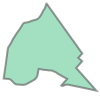

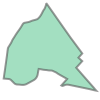

None

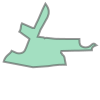

In [49]:
#Show a random difference
test = shp_final_merge[~vals].sample(axis = 0, n=1).index[0]
print(shp_final_merge[~vals])
display(shp_final_merge.iloc[test]['geometry_x'])
display(shp_final_merge.iloc[test]['geometry_y'])

test = shp_final_merge[~vals].sample(axis = 0).index[0]
display(shp_final_merge.iloc[test]['geometry_x'])
display(shp_final_merge.iloc[test]['geometry_y'])

### County 650 ex

(3, 64)


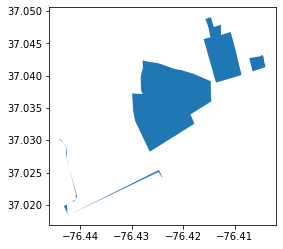

In [50]:
print(shp_final_merge[shp_final_merge['unique_id'].str[0:3] == '650'].shape)
ex_x = gpd.GeoDataFrame(shp_final_merge[shp_final_merge['unique_id'].str[0:3]== '650'], geometry = 'geometry_x', crs = proj)
ex_y = gpd.GeoDataFrame(shp_final_merge[shp_final_merge['unique_id'].str[0:3]== '650'], geometry = 'geometry_y', crs = proj)

gpd.overlay(ex_x, ex_y, how = 'symmetric_difference').plot()

## Validating Election Results

In [52]:
final.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'SOV_DIST', 'S16SOVDEM',
       'S16SOVREP', 'S16SOVIND', 'S16SOVWRI', 'geometry', 'unique_id'],
      dtype='object')

In [53]:
column_list = ['S16SOVDEM', 'S16SOVREP', 'S16SOVIND', 'S16SOVWRI']

In [54]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_id'])
                if (diff>max_diff):
                    max_diff = diff
                    #add line to check percent from total vote difference is
                    perc_diff_from_vest = (diff/df.iloc[j][right_Data])*100
                    print("New max diff is: ", str(max_diff))
                    print('% difference from VEST total is: ', str(perc_diff_from_vest))
                    print(df.iloc[j]['unique_id'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_id'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        #add line for % of total vote that difference is
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()

In [65]:
final_join_merge = pd.merge(join, final, on = 'unique_id', how = 'inner', suffixes = ['_x', '_y'])

In [66]:
validater_row(final_join_merge, column_list)

New max diff is:  1.0
% difference from VEST total is:  0.11862396204033215
650214
There are  90  total rows
47  of these rows have election result differences
43  of these rows are the same

The max difference between any one shared column in a row is:  1.0
The average difference is:  1.0
There are  0 precinct results with a difference greater than 5
